In [1]:
# Import libraries
import numpy as np
import mne
from matplotlib import pyplot as plt
import seaborn as sns
import tomli
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from toeplitzlda.classification import ToeplitzLDA
from rslda import RSLDA, SeparateLDA

c:\Users\ellah\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Load data

In [2]:
non_eeg_channels = ['EOGvu', 'x_EMGl', 'x_GSR', 'x_Respi', 'x_Pulse', 'x_Optic']
all_data = []
path_settings = tomli.load(open("data_path.toml", "rb"))
path = path_settings["data_path"] + path_settings["participant"] + path_settings["paradigm"] + path_settings["condition"] + path_settings["block"]
run = path_settings["run"]
for b in range(run,run+12,3):
    eeg_filepath = f"{path}{b}.vhdr"
    eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
    eeg_data.set_montage('standard_1020').load_data()
    all_data.append(eeg_data)

C:\Users\ellah\AppData\Local\Temp\ipykernel_15900\535688340.py:8: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
C:\Users\ellah\AppData\Local\Temp\ipykernel_15900\535688340.py:8: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
C:\Users\ellah\AppData\Local\Temp\ipykernel_15900\535688340.py:8: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
C:\Users\ellah\AppData\Local\Temp\ipykernel_15900\535688340.py:8: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 H

## Preprocess data

In [3]:
def preprocessed_to_epoch(preprocessed_data, decimate=1, baseline_ival=None, tmin=-.2, tmax=1.2):
    """
    From the course Brain-Computer Interfacing, assignment 6
    Added tmin and tmax parameters
    Decimate set to downsampling to 100 Hz
    Class IDs expanded
    """
    raw_stim_ids = {"Stimulus/S101": 101, "Stimulus/S111": 111,
                    "Stimulus/S102": 102, "Stimulus/S112": 112,
                    "Stimulus/S103": 103, "Stimulus/S113": 113,
                    "Stimulus/S104": 104, "Stimulus/S114": 114,
                    "Stimulus/S105": 105, "Stimulus/S115": 115,
                    "Stimulus/S106": 106, "Stimulus/S116": 116
                   }
    class_ids = {"Non-Target 1": 101, "Target 1": 111,
                 "Non-Target 2": 102, "Target 2": 112,
                 "Non-Target 3": 103, "Target 3": 113,
                 "Non-Target 4": 104, "Target 4": 114,
                 "Non-Target 5": 105, "Target 5": 115,
                 "Non-Target 6": 106, "Target 6": 116
                 }
    reject = None
    events = mne.events_from_annotations(preprocessed_data, event_id=raw_stim_ids)[0]
    epo_data = mne.Epochs(preprocessed_data, events, event_id=class_ids, tmin=tmin, tmax=tmax,
                          baseline=baseline_ival, decim=decimate,
                          reject=reject, proj=False, preload=True)
    return epo_data

In [4]:
# Preprocess data

# Downsampling 100 Hz
# Epoching [-200, 1200] ms

filter_band = (0.5, 16)

baseline_ival = None

# Read, preprocess, and slice the data
epo_arr = []
for i in range(len(all_data)):
    all_data[i].filter(filter_band[0], filter_band[1], method='iir')
    all_data[i].pick_types(eeg=True)
    n_channels = len(all_data[i].info.get('ch_names'))
    fs = all_data[i].info.get('sfreq')
    epo_data = preprocessed_to_epoch(all_data[i], decimate=fs//100, baseline_ival=baseline_ival)
    epo_arr.append(epo_data)

Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116']
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
Loading data for 540 events and 1401 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116']
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
Loading data for 540 events and 1401 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S11

## Visualisations

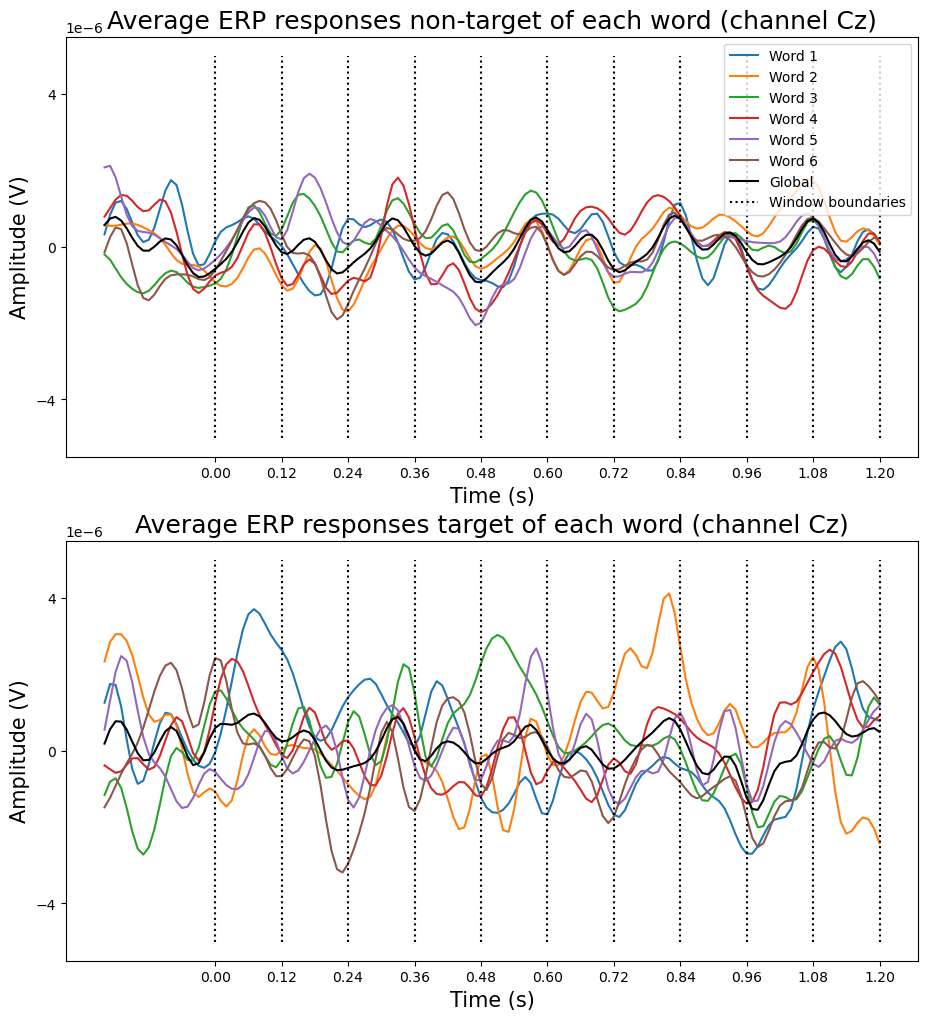

In [5]:
# Average ERP for channels for each of the words (split by target/non-target)
plot_channels = ['Cz']
boundaries = np.linspace(0, 1.2, 11)
plt.figure(figsize=[11,12])

def avg_epoch(epo_arr, event, channels):
    all_data = np.array([])
    for epo in epo_arr:
        evo = epo[event].average(picks=channels)
        times = evo.times
        data = evo.data
        if len(all_data) == 0:
            all_data = data
        else:
            all_data = np.append(all_data, data, axis=0)
    mean_data = np.mean(all_data, axis=0)
    return mean_data, times
    

ax_t = plt.subplot(2,1,2)
for i in range(6):
    evo_t, t = avg_epoch(epo_arr, f'Target {i+1}', plot_channels)
    for ch_i, ch in enumerate(plot_channels):
        ax_t.plot(t, evo_t, label=f'Word {i+1}')
ax_t.set_ylabel('Amplitude (V)', fontsize=15)
ax_t.set_xlabel('Time (s)', fontsize=15)
ax_t.set_title(f'Average ERP responses target of each word (channel Cz)', fontsize=18)
evo_t, t = avg_epoch(epo_arr, ['Target 1', 'Target 2', 'Target 3',
                               'Target 4', 'Target 5', 'Target 6'],
                     plot_channels)
ax_t.plot(t, evo_t, color='k', label='Global')
ax_t.vlines(boundaries, -5*10**-6, 5*10**-6, colors='k', linestyles='dotted', label='Window boundaries')
ax_t.set_yticks([-4e-6, 0, 4e-6])
ax_t.set_xticks(boundaries)

ax_nt = plt.subplot(2,1,1)
for i in range(6):
    evo_nt, t = avg_epoch(epo_arr, f'Non-Target {i+1}', plot_channels)
    for ch_i, ch in enumerate(plot_channels):
        ax_nt.plot(t, evo_nt, label=f'Word {i+1}')
ax_nt.set_ylabel('Amplitude (V)', fontsize=15)
ax_nt.set_xlabel('Time (s)', fontsize=15)
ax_nt.set_title(f'Average ERP responses non-target of each word (channel Cz)', fontsize=18)
evo_nt, t = avg_epoch(epo_arr, ['Non-Target 1', 'Non-Target 2', 'Non-Target 3',
                                'Non-Target 4', 'Non-Target 5', 'Non-Target 6'],
                      plot_channels)
ax_nt.plot(t, evo_nt, color='k', label='Global')
ax_nt.vlines(boundaries, -5*10**-6, 5*10**-6, colors='k', linestyles='dotted', label='Window boundaries')
ax_nt.legend()
ax_nt.set_yticks([-4e-6, 0, 4e-6])
ax_nt.set_xticks(boundaries)
plt.savefig('3HP_avg_non_target_erp.svg')
plt.show()

## Feature Extraction

In [6]:
# Feature extraction
boundaries = np.linspace(0, 1.2, 11)  # Time windows of equal length for best performance of block-Toeplitz
print(boundaries)
def get_jumping_means(epo, boundaries):
    """
    From the course Brain-Computer Interfacing, assignment 6
    """
    shape_orig = epo.get_data().shape
    features = np.zeros((shape_orig[0], shape_orig[1], len(boundaries)-1))
    for i in range(len(boundaries)-1):
        idx = epo.time_as_index((boundaries[i], boundaries[i+1]))
        idx_range = list(range(idx[0], idx[1]))
        features[:,:,i] = epo.get_data()[:,:,idx_range].mean(axis=2)
    return features

# Extract the data
for i in range(len(epo_arr)):
    X_epo = get_jumping_means(epo_arr[i], boundaries).squeeze()
    X_epo = X_epo.reshape(X_epo.shape[0], X_epo.shape[1]*X_epo.shape[2]) # flattens
    y_epo = [(z - 100) // 10 for [x,y,z] in epo_arr[i].events]
    sublabel = [(z % 100) % 10 for [x,y,z] in epo_arr[i].events]
    if i == 0:
        X = X_epo
        y = y_epo
        sublabs = sublabel
    else:
        X = np.append(X, X_epo, axis=0)
        y = np.append(y, y_epo)
        sublabs = np.append(sublabs, sublabel)

[0.   0.12 0.24 0.36 0.48 0.6  0.72 0.84 0.96 1.08 1.2 ]


## Decoding

In [7]:
# Decoding with global block-Toeplitz LDA
lda_bt = ToeplitzLDA(n_channels=n_channels, data_is_channel_prime=False)
lda_bt.fit(X, y)

lda_lw = LDA(solver='eigen', shrinkage='auto')
lda_lw = lda_lw.fit(X, y)

In [8]:
# Decoding with RSLDA
rsLDA_bt = RSLDA(n_channels=n_channels)
rsLDA_bt = rsLDA_bt.fit(X, y, sublabs, whitening=True)

rsLDA_lw = RSLDA(n_channels=n_channels)
rsLDA_lw = rsLDA_lw.fit(X, y, sublabs, whitening=True, toeplitz=False)

rsLDA_global_t = RSLDA(n_channels=n_channels)
rsLDA_global_t = rsLDA_global_t.fit(X, y, sublabs, global_mean=[False, True])

rsLDA_global_nt = RSLDA(n_channels=n_channels)
rsLDA_global_nt = rsLDA_global_nt.fit(X, y, sublabs)

In [9]:
# Decoding with separate classifiers without mean regularization
sepLDA_bt = SeparateLDA(n_channels)
sepLDA_bt = sepLDA_bt.fit(X, y, sublabs, toeplitz=True, share_cov=False)

sepLDA_lw = SeparateLDA()
sepLDA_lw = sepLDA_lw.fit(X, y, sublabs, toeplitz=False, share_cov=False)

## Testing

In [10]:
# Load holdout data
non_eeg_channels = ['EOGvu', 'x_EMGl', 'x_GSR', 'x_Respi', 'x_Pulse', 'x_Optic']
test_data = []
for b in range(run+12,run+16,3):
    eeg_filepath = f"{path}{b}.vhdr"
    eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
    eeg_data.set_montage('standard_1020').load_data()
    test_data.append(eeg_data)

# Epoch test data   
test_arr = []
for i in range(len(test_data)):
    test_data[i].filter(filter_band[0], filter_band[1], method='iir')
    test_data[i].pick_types(eeg=True)
    n_channels = len(test_data[i].info.get('ch_names'))
    fs = test_data[i].info.get('sfreq')
    epo_data = preprocessed_to_epoch(test_data[i], decimate=fs//100, baseline_ival=baseline_ival)
    test_arr.append(epo_data)

C:\Users\ellah\AppData\Local\Temp\ipykernel_15900\2429993704.py:6: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
C:\Users\ellah\AppData\Local\Temp\ipykernel_15900\2429993704.py:6: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)


Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116']
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
Loading data for 540 events and 1401 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116']
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
Loading data for 540 events and 1401 original time points ...
0 bad epochs dropped


In [11]:
# Get test features
for i in range(len(test_arr)):
    X_epo = get_jumping_means(test_arr[i], boundaries).squeeze()
    X_epo = X_epo.reshape(X_epo.shape[0], X_epo.shape[1]*X_epo.shape[2]) # flattens
    y_epo = [(i-100)//10 for [x,j,i] in test_arr[i].events]
    sublabel = [(z % 100) % 10 for [x,y,z] in test_arr[i].events]
    if i == 0:
        X_test = X_epo
        y_test = y_epo
        sublabs_test = sublabel
    else:
        X_test = np.append(X_test, X_epo, axis=0)
        y_test = np.append(y_test, y_epo)
        sublabs_test = np.append(sublabs_test, sublabel)

In [12]:
def compute_auc(model, sub_aware, X_test, sublabs_test, y_test):
    """Compute the AUC score and the classification probabilities.
    model: the classifier
    sub_aware: Bool
        Whether subclass labels are used
        and thus should be passed to predict_proba
    X_test: the test data
    sublabs_test: the subclass labels of the test data
    y_test: the main class labels of the tets data
    """
    if sub_aware:
        y_score = model.predict_proba(X_test, sublabs_test)[:,1]
    else:
        y_score = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_score)
    return auc_score, y_score

# The models to be tested and their names, whether they use subclasses,
# and what color and linestyle they will be plotted with
models = [lda_bt, lda_lw, rsLDA_bt, rsLDA_lw, sepLDA_bt, sepLDA_lw]
model_names = ['Global ToeplitzLDA', 'Global sLDA',
               'ToeplitzRSLDA', 'sRSLDA',
               'Sep. ToeplitzLDA', 'Sep. sLDA']
model_subclass_aware = [False, False, True, True, True, True]
colors = ['r', 'r', 'b', 'r', 'c', 'm']
linestyles = [':', ':', '-', '-', '-', '-']

# Calculate all AUC scores
aucs = np.zeros(len(model_names))
y_scores = np.zeros((len(model_names),len(y_test)))
for i in range(len(models)):
    aucs[i], y_scores[i,:] = compute_auc(models[i], model_subclass_aware[i], X_test, sublabs_test, y_test)

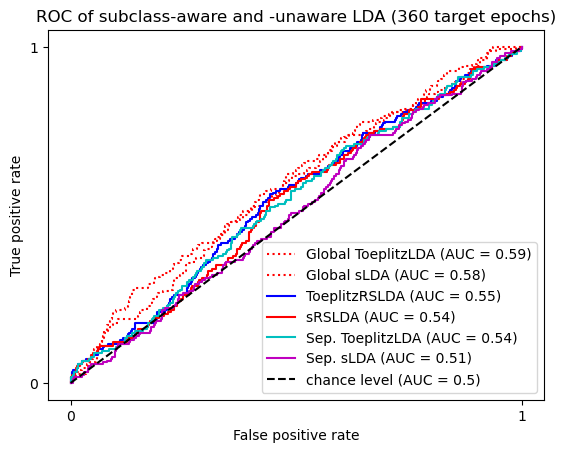

In [13]:
def plot_roc(model_name, y_test, y_score, AUC, color, linestyle):
    """Plot the ROC curve
    model_name: str
    y_test: the true class labels of the test set
    y_score: the probabilities of predicting each class for each test data point
    AUC: float
        the AUC score of the model
    color: str
        the plotting color
    linestyle: str
        the plotting linestyle
    """
    [fpr, tpr, thresholds] = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {round(AUC, 2)})', color=color, linestyle=linestyle)

for i in range(len(model_names)):
    plot_roc(model_names[i], y_test, y_scores[i], aucs[i], colors[i], linestyles[i])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.title(f'ROC of subclass-aware and -unaware LDA ({4*6*15} target epochs)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks([0,1])
plt.yticks([0,1])

plt.savefig("1HP_euclidean.svg")

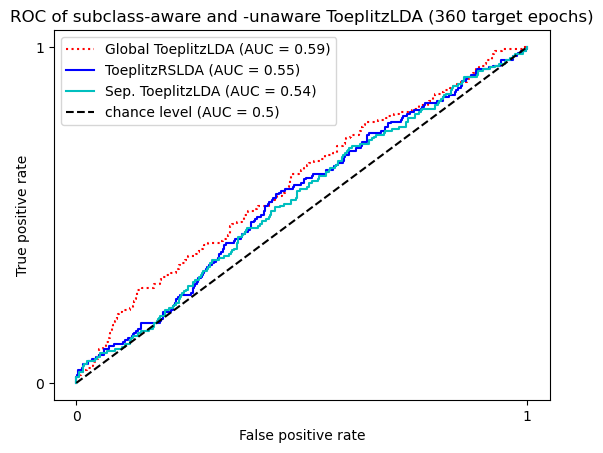

In [14]:
# ROC curves of all block-Toeplitz models
bt_indices = [0, 2, 4]
for i in bt_indices:
    plot_roc(model_names[i], y_test, y_scores[i], aucs[i], colors[i], linestyles[i])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.title(f'ROC of subclass-aware and -unaware ToeplitzLDA ({4*6*15} target epochs)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks([0,1])
plt.yticks([0,1])
plt.savefig('1HP_roc_rslda_bt.svg')

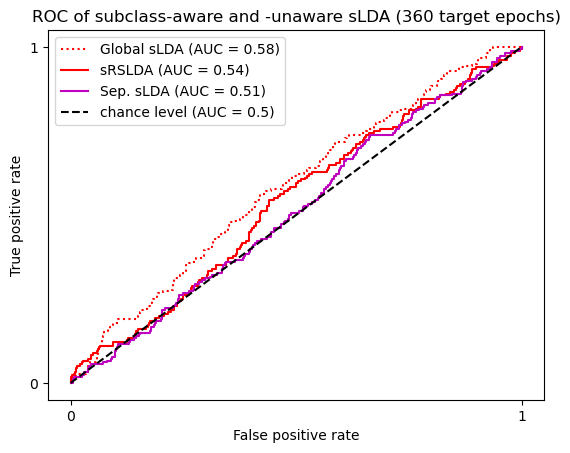

In [15]:
# ROC curves of all block-Toeplitz models
bt_indices = [1, 3, 5]
for i in bt_indices:
    plot_roc(model_names[i], y_test, y_scores[i], aucs[i], colors[i], linestyles[i])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.title(f'ROC of subclass-aware and -unaware sLDA ({4*6*15} target epochs)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks([0,1])
plt.yticks([0,1])

plt.savefig('1HP_roc_rslda_lw.svg')

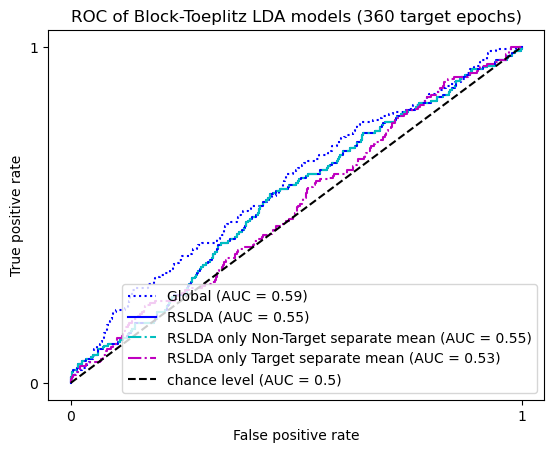

In [16]:
# ROC curves of Block-Toeplitz models, with global mean for one of the classes
models_m = [lda_bt, rsLDA_bt, rsLDA_global_nt, rsLDA_global_t]
model_names_m = ['Global', 'RSLDA', 'RSLDA only Non-Target separate mean', 'RSLDA only Target separate mean']
model_subclass_aware_m = [False, True, True, True]
colors_m = ['b', 'b', 'c', 'm']
linestyles_m = [':', '-', '-.', '-.']

aucs_m = np.zeros(len(model_names_m))
y_scores = np.zeros((len(model_names_m),len(y_test)))
for i in range(len(model_names_m)):
    aucs_m[i], y_scores[i,:] = compute_auc(models_m[i], model_subclass_aware_m[i], X_test, sublabs_test, y_test)

for i in range(len(model_names_m)):
    plot_roc(model_names_m[i], y_test, y_scores[i], aucs_m[i], colors_m[i], linestyles_m[i])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.title(f'ROC of Block-Toeplitz LDA models ({4*6*15} target epochs)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks([0,1])
plt.yticks([0,1])

plt.savefig('1HP_half_models.svg')

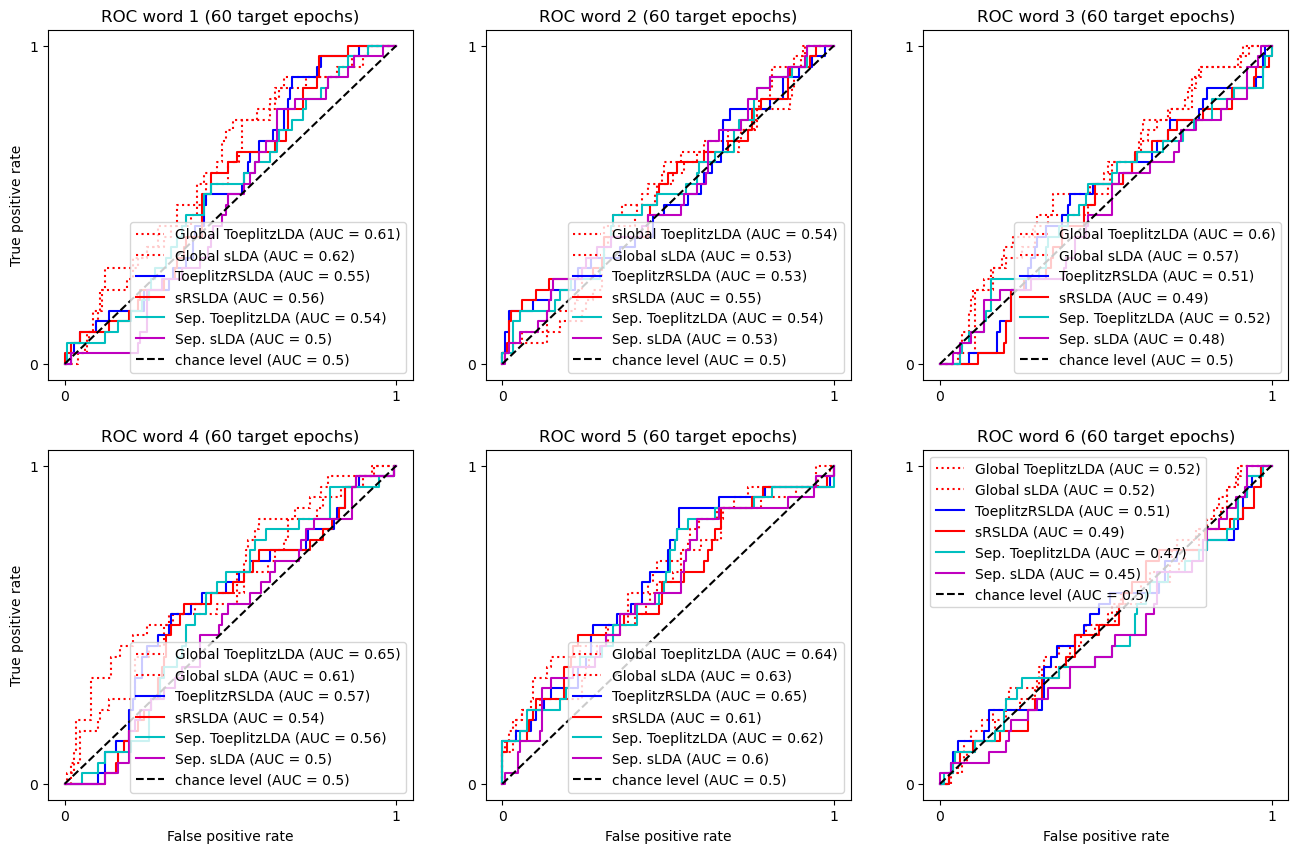

In [17]:
# ROC curves per subclass
fig, axs = plt.subplots(2, 3, figsize=[16,10])
auc_subs = np.zeros((6, len(models)))

for i in range(6):
    axx = i % 3
    axy = i // 3
    for j in range(len(models)):
        y_test_sub = y_test[sublabs_test==i+1]
        X_test_sub = X_test[sublabs_test==i+1,:]
        subs = np.array([i+1] * len(y_test_sub))
        auc_subs[i,j], y_score_sub = compute_auc(models[j], model_subclass_aware[j], X_test_sub, subs, y_test_sub)
        [fpr, tpr, thresholds] = roc_curve(y_test_sub, y_score_sub)
        axs[axy,axx].plot(fpr, tpr, label=f'{model_names[j]} (AUC = {round(auc_subs[i,j], 2)})', color=colors[j], linestyle=linestyles[j])
    if axx == 0:
        axs[axy,axx].set_ylabel('True positive rate')
    if axy == 1:
        axs[axy,axx].set_xlabel('False positive rate')
    axs[axy,axx].set_title(f'ROC word {i+1} ({4*15} target epochs)')
    axs[axy,axx].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    axs[axy,axx].legend()
    axs[axy,axx].set_xticks([0,1])
    axs[axy,axx].set_yticks([0,1])

    plt.savefig('1HP_euclidean_sub.svg')

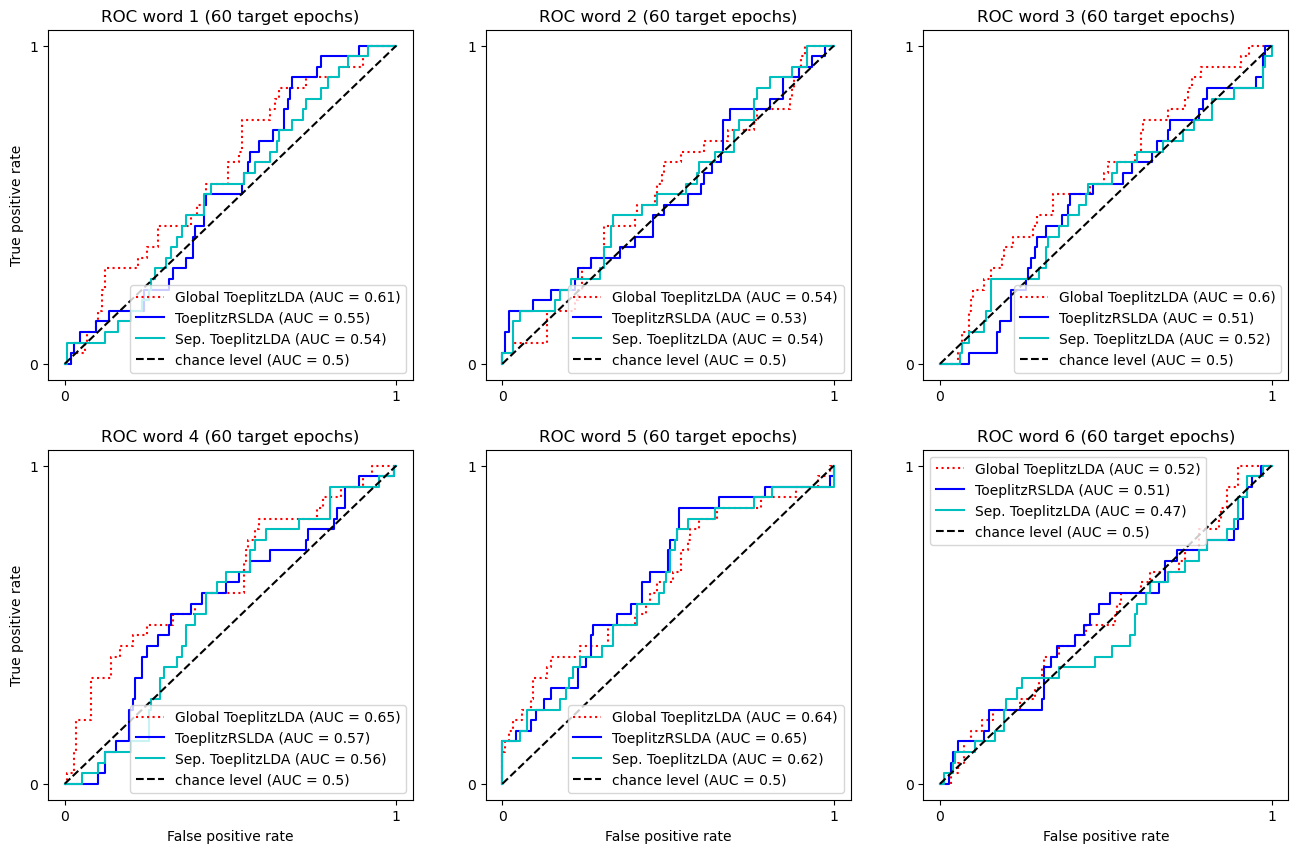

In [18]:
# ROC curves per subclass
fig, axs = plt.subplots(2, 3, figsize=[16,10])

for i in range(6):
    axx = i % 3
    axy = i // 3
    for j in range(0, 5, 2):
        y_test_sub = y_test[sublabs_test==i+1]
        X_test_sub = X_test[sublabs_test==i+1,:]
        subs = np.array([i+1] * len(y_test_sub))
        auc_sub, y_score_sub = compute_auc(models[j], model_subclass_aware[j], X_test_sub, subs, y_test_sub)
        [fpr, tpr, thresholds] = roc_curve(y_test_sub, y_score_sub)
        axs[axy,axx].plot(fpr, tpr, label=f'{model_names[j]} (AUC = {round(auc_sub, 2)})', color=colors[j], linestyle=linestyles[j])
    if axx == 0:
        axs[axy,axx].set_ylabel('True positive rate')
    if axy == 1:
        axs[axy,axx].set_xlabel('False positive rate')
    axs[axy,axx].set_title(f'ROC word {i+1} ({4*15} target epochs)')
    axs[axy,axx].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    axs[axy,axx].legend()
    axs[axy,axx].set_xticks([0,1])
    axs[axy,axx].set_yticks([0,1])

    plt.savefig('1HP_roc_bt_sub.svg')

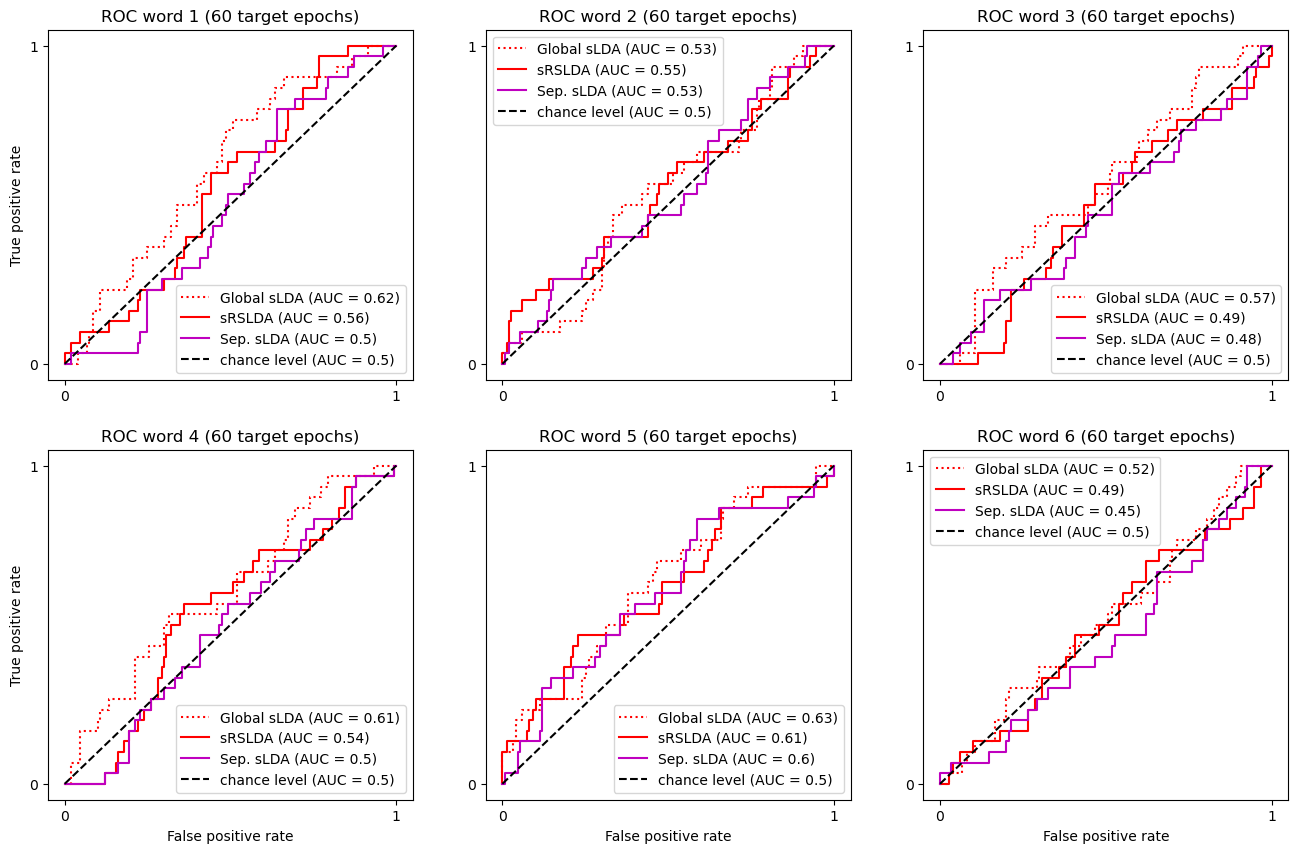

In [19]:
# ROC curves per subclass
fig, axs = plt.subplots(2, 3, figsize=[16,10])

for i in range(6):
    axx = i % 3
    axy = i // 3
    for j in range(1, 6, 2):
        y_test_sub = y_test[sublabs_test==i+1]
        X_test_sub = X_test[sublabs_test==i+1,:]
        subs = np.array([i+1] * len(y_test_sub))
        auc_sub, y_score_sub = compute_auc(models[j], model_subclass_aware[j], X_test_sub, subs, y_test_sub)
        [fpr, tpr, thresholds] = roc_curve(y_test_sub, y_score_sub)
        axs[axy,axx].plot(fpr, tpr, label=f'{model_names[j]} (AUC = {round(auc_sub, 2)})', color=colors[j], linestyle=linestyles[j])
    if axx == 0:
        axs[axy,axx].set_ylabel('True positive rate')
    if axy == 1:
        axs[axy,axx].set_xlabel('False positive rate')
    axs[axy,axx].set_title(f'ROC word {i+1} ({4*15} target epochs)')
    axs[axy,axx].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    axs[axy,axx].legend()
    axs[axy,axx].set_xticks([0,1])
    axs[axy,axx].set_yticks([0,1])

    plt.savefig('1HP_roc_lw_sub.svg')

In [20]:
from scipy.stats import wilcoxon

# Write p-values to a file in a way that can be easily made into a Latex table
file = open("p_values.txt", "a")
for i in range(2, 6):
    if aucs[i] > aucs[i % 2]:
        stats = wilcoxon(auc_subs[:,i % 2], auc_subs[:,i], alternative='less')
        file.write(f"{model_names[i]} & {model_names[i % 2]} & {path_settings['participant']} & {path_settings['condition']} & {stats.pvalue} \\\\ \n")

file.close()